## Regresor

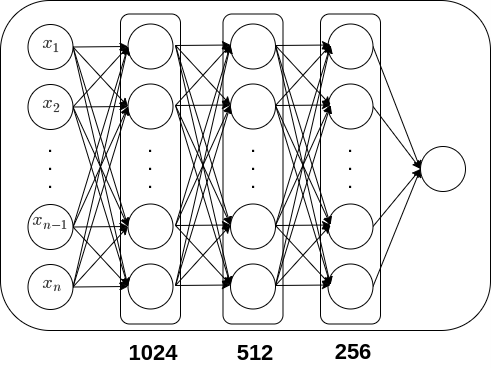

In [ ]:
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import utils
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras import models
from tensorflow.keras import regularizers

!pip install tensorflow_addons
from tensorflow_addons.metrics import RSquare

     |████████████████████████████████| 1.1 MB 4.3 MB/s 


In [ ]:
# Una forma de cargar el dataset
%%capture
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1IDPzkXd8OVEPAZmujhgR1rXs_dXHOFJj' -O- | sed -rn 's/.confirm=([0-9A-Za-z_]+)./\1\n/p')&id=1IDPzkXd8OVEPAZmujhgR1rXs_dXHOFJj" -O data.csv && rm -rf /tmp/cookies.txt

In [ ]:
#Para leer los datos
df = pd.read_csv('data.csv',header=None)
#df #base de datos FCM

In [ ]:
#Separación por escenarios

df_B2B=df.iloc[0:987,:] #Back to back

df_fiber_0=df.iloc[988:1520,:] #Con fibra a 0dBm

df_fiber_9=df.iloc[1521:,:] #Con fibra a 9dBm

## Modelo Relu con parada por iteraciones

In [ ]:
data = df_B2B # se coloca el dataset de interés
variables = 17

#Separando variables
X = data.iloc[:,0:variables].values #Variables
y = data.iloc[:,19:20].values #etiquetas
list_X = list(range(variables))

from time import time
t0 = time()

# Lista para almacenar los valores de AAE
mean_abs_errs_relu_i1 = []
mean_abs_errs_relu_i2 = []
mean_abs_errs_relu_i3 = []

r2_relu_i1 = []
r2_relu_i2 = []
r2_relu_i3 = []

# Se hace un K-Fold
kf = KFold()

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #Estandarización de las variables de entrada
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test_kf = sc.transform(X_test)
    X_test_all = sc.transform(X)

    # Basados en los resultados en el clasificador se aplicarán las correcciones
    # modelo con paradas por iteraciones
    model = Sequential()

    model.add(Dense(units=256, input_dim=len(list_X), activation='relu')) #capa 1
    model.add(Dense(units=128, activation='tanh')) #capa 2
    model.add(Dense(units=64, activation='sigmoid')) #capa 3
    model.add(Dense(1, activation='linear')) #Regresor
    
    model.compile(loss='mean_absolute_error', optimizer='adam')
    
    history_1 = model.fit(X_train, y_train, epochs=5000, batch_size=64, verbose=0)
    print(len(history_1.history['loss']))
    
    Train_predictions_1 = model.predict(X_train) # Se predicen los datos de entrenamiento
    Train_predictions_2 = model.predict(X_test_kf) # Se predicen los datos de prueba KF
    Train_predictions_3 = model.predict(X_test_all) # Se predicen todos los datos de prueba

    #Se crea un dataframe con los resultados para visualizarlos mejor
    TrainData_1 = pd.DataFrame(data=y_train, columns=['ICI'])
    TrainData_1['PreICI'] = Train_predictions_1

    TrainData_2 = pd.DataFrame(data=y_test, columns=['ICI'])
    TrainData_2['PreICI'] = Train_predictions_2
    
    TrainData_3 = pd.DataFrame(data=y, columns=['ICI'])
    TrainData_3['PreICI'] = Train_predictions_3

    # Cálculo del MAE
    mae1 = mean_absolute_error(TrainData_1['ICI'],TrainData_1['PreICI'])
    mae2 = mean_absolute_error(TrainData_2['ICI'],TrainData_2['PreICI'])
    mae3 = mean_absolute_error(TrainData_3['ICI'],TrainData_3['PreICI'])

    # Cálculo de R²
    r2_metric = RSquare()

    r2_metric.update_state(TrainData_1['ICI'], TrainData_1['PreICI'])
    r2_1 = r2_metric.result().numpy()

    r2_metric.update_state(TrainData_2['ICI'], TrainData_2['PreICI'])
    r2_2 = r2_metric.result().numpy()

    r2_metric.update_state(TrainData_3['ICI'], TrainData_3['PreICI'])
    r2_3 = r2_metric.result().numpy()

    # Anexo a las listas
    mean_abs_errs_relu_i1.append(mae1)
    mean_abs_errs_relu_i2.append(mae2)
    mean_abs_errs_relu_i3.append(mae3)

    r2_relu_i1.append(r2_1)
    r2_relu_i2.append(r2_2)
    r2_relu_i3.append(r2_3)

print(f'Tiempo transcurrido: {(time() - t0)/60:.2f} minutos')

5000
5000
5000
5000
5000
Tiempo transcurrido: 10.89 minutos


## Modelo Swish con parada por iteraciones

In [ ]:
data = df_B2B # se coloca el dataset de interés
variables = 17

#Separando variables
X = data.iloc[:,0:variables].values #Variables
y = data.iloc[:,19:20].values #etiquetas
list_X = list(range(variables))

from time import time
t0 = time()

# Lista para almacenar los valores de AAE
mean_abs_errs_swish_i1 = []
mean_abs_errs_swish_i2 = []
mean_abs_errs_swish_i3 = []

r2_swish_i1 = []
r2_swish_i2 = []
r2_swish_i3 = []

# Se hace un K-Fold
kf = KFold()

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #Estandarización de las variables de entrada
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test_kf = sc.transform(X_test)
    X_test_all = sc.transform(X)

    # Basados en los resultados en el clasificador se aplicarán las correcciones
    # modelo con paradas por iteraciones
    model = Sequential()

    model.add(Dense(units=256, input_dim=len(list_X), activation='swish')) #capa 1
    model.add(Dense(units=128, activation='tanh')) #capa 2
    model.add(Dense(units=64, activation='sigmoid')) #capa 3
    model.add(Dense(1, activation='linear')) #Regresor
    
    model.compile(loss='mean_absolute_error', optimizer='adam')
    
    history_1 = model.fit(X_train, y_train, epochs=5000, batch_size=64, verbose=0)
    print(len(history_1.history['loss']))
    
    Train_predictions_1 = model.predict(X_train) # Se predicen los datos de entrenamiento
    Train_predictions_2 = model.predict(X_test_kf) # Se predicen los datos de prueba KF
    Train_predictions_3 = model.predict(X_test_all) # Se predicen todos los datos de prueba

    #Se crea un dataframe con los resultados para visualizarlos mejor
    TrainData_1 = pd.DataFrame(data=y_train, columns=['ICI'])
    TrainData_1['PreICI'] = Train_predictions_1

    TrainData_2 = pd.DataFrame(data=y_test, columns=['ICI'])
    TrainData_2['PreICI'] = Train_predictions_2
    
    TrainData_3 = pd.DataFrame(data=y, columns=['ICI'])
    TrainData_3['PreICI'] = Train_predictions_3

    # Cálculo del MAE
    mae1 = mean_absolute_error(TrainData_1['ICI'],TrainData_1['PreICI'])
    mae2 = mean_absolute_error(TrainData_2['ICI'],TrainData_2['PreICI'])
    mae3 = mean_absolute_error(TrainData_3['ICI'],TrainData_3['PreICI'])

    # Cálculo de R²
    r2_metric = RSquare()

    r2_metric.update_state(TrainData_1['ICI'], TrainData_1['PreICI'])
    r2_1 = r2_metric.result().numpy()

    r2_metric.update_state(TrainData_2['ICI'], TrainData_2['PreICI'])
    r2_2 = r2_metric.result().numpy()

    r2_metric.update_state(TrainData_3['ICI'], TrainData_3['PreICI'])
    r2_3 = r2_metric.result().numpy()

    # Anexo a las listas
    mean_abs_errs_swish_i1.append(mae1)
    mean_abs_errs_swish_i2.append(mae2)
    mean_abs_errs_swish_i3.append(mae3)

    r2_swish_i1.append(r2_1)
    r2_swish_i2.append(r2_2)
    r2_swish_i3.append(r2_3)

print(f'Tiempo transcurrido: {(time() - t0)/60:.2f} minutos')

5000
5000
5000
5000
5000
Tiempo transcurrido: 11.26 minutos


## Modelo Swish regularizado con parada por iteraciones

In [ ]:
data = df_B2B # se coloca el dataset de interés
variables = 17

#Separando variables
X = data.iloc[:,0:variables].values #Variables
y = data.iloc[:,19:20].values #etiquetas
list_X = list(range(variables))

from time import time
t0 = time()

# Lista para almacenar los valores de AAE
mean_abs_errs_swish_i1_r = []
mean_abs_errs_swish_i2_r = []
mean_abs_errs_swish_i3_r = []

r2_swish_i1_r = []
r2_swish_i2_r = []
r2_swish_i3_r = []

# Se hace un K-Fold
kf = KFold()

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #Estandarización de las variables de entrada
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test_kf = sc.transform(X_test)
    X_test_all = sc.transform(X)

    # Basados en los resultados en el clasificador se aplicarán las correcciones
    # modelo con paradas por iteraciones
    model = Sequential()

    model.add(Dense(units=256, input_dim=len(list_X), activation='swish',
                    kernel_regularizer=regularizers.L1(0.1),
                    activity_regularizer=regularizers.L2(0.1))) #capa 1
    model.add(Dense(units=128, activation='tanh')) #capa 2
    model.add(Dense(units=64, activation='sigmoid')) #capa 3
    model.add(Dense(1, activation='linear')) #Regresor
    
    model.compile(loss='mean_absolute_error', optimizer='adam')
    
    history_1 = model.fit(X_train, y_train, epochs=5000, batch_size=64, verbose=0)
    print(len(history_1.history['loss']))
    
    Train_predictions_1 = model.predict(X_train) # Se predicen los datos de entrenamiento
    Train_predictions_2 = model.predict(X_test_kf) # Se predicen los datos de prueba KF
    Train_predictions_3 = model.predict(X_test_all) # Se predicen todos los datos de prueba

    #Se crea un dataframe con los resultados para visualizarlos mejor
    TrainData_1 = pd.DataFrame(data=y_train, columns=['ICI'])
    TrainData_1['PreICI'] = Train_predictions_1

    TrainData_2 = pd.DataFrame(data=y_test, columns=['ICI'])
    TrainData_2['PreICI'] = Train_predictions_2
    
    TrainData_3 = pd.DataFrame(data=y, columns=['ICI'])
    TrainData_3['PreICI'] = Train_predictions_3

    # Cálculo del MAE
    mae1 = mean_absolute_error(TrainData_1['ICI'],TrainData_1['PreICI'])
    mae2 = mean_absolute_error(TrainData_2['ICI'],TrainData_2['PreICI'])
    mae3 = mean_absolute_error(TrainData_3['ICI'],TrainData_3['PreICI'])

    # Cálculo de R²
    r2_metric = RSquare()

    r2_metric.update_state(TrainData_1['ICI'], TrainData_1['PreICI'])
    r2_1 = r2_metric.result().numpy()

    r2_metric.update_state(TrainData_2['ICI'], TrainData_2['PreICI'])
    r2_2 = r2_metric.result().numpy()

    r2_metric.update_state(TrainData_3['ICI'], TrainData_3['PreICI'])
    r2_3 = r2_metric.result().numpy()

    # Anexo a las listas
    mean_abs_errs_swish_i1_r.append(mae1)
    mean_abs_errs_swish_i2_r.append(mae2)
    mean_abs_errs_swish_i3_r.append(mae3)

    r2_swish_i1_r.append(r2_1)
    r2_swish_i2_r.append(r2_2)
    r2_swish_i3_r.append(r2_3)

print(f'Tiempo transcurrido: {(time() - t0)/60:.2f} minutos')

5000
5000
5000
5000
5000
Tiempo transcurrido: 11.69 minutos


## Gráfica de errores medios ReLu vs. Swish

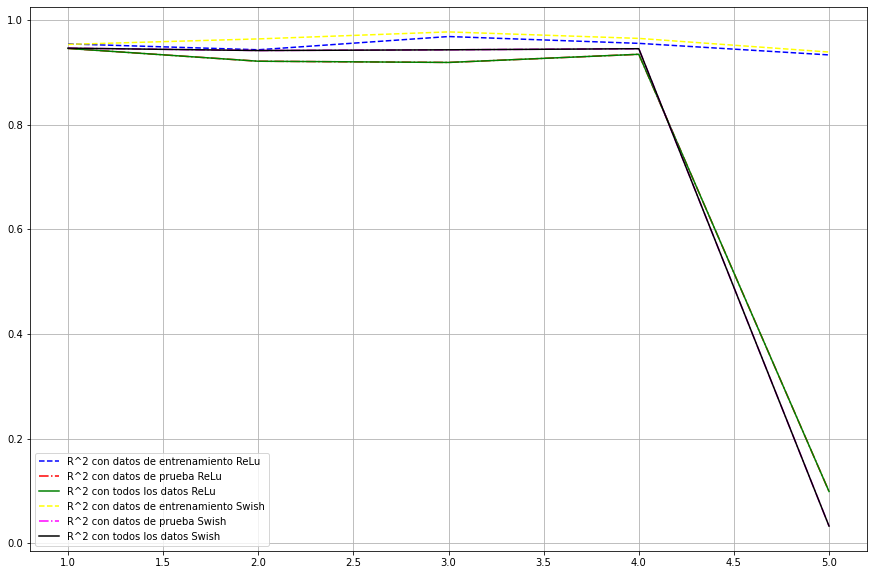

In [ ]:
plt.figure(figsize=(15,10))
linestyles = ["dashed", "dashdot", "solid"]*2
colors = ["blue", "red", "green", "yellow", "magenta", "black"]
points = [r2_relu_i1, r2_relu_i2, r2_relu_i3,
          r2_swish_i1, r2_swish_i2, r2_swish_i3]
labels = ["R^2 con datos de entrenamiento ReLu",
          "R^2 con datos de prueba ReLu",
          "R^2 con todos los datos ReLu",
          "R^2 con datos de entrenamiento Swish",
          "R^2 con datos de prueba Swish",
          "R^2 con todos los datos Swish"]
for i in range(6):
    plt.plot(range(1, 6), points[i], linestyle=linestyles[i], color=colors[i], label=labels[i])
plt.grid(True)
plt.legend()

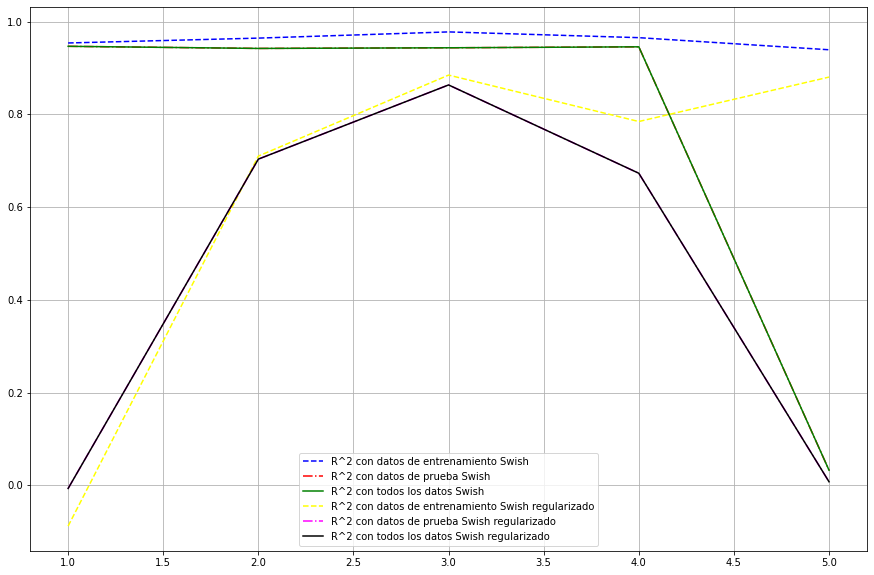

In [ ]:
plt.figure(figsize=(15,10))
linestyles = ["dashed", "dashdot", "solid"]*2
colors = ["blue", "red", "green", "yellow", "magenta", "black"]
points = [r2_swish_i1, r2_swish_i2, r2_swish_i3,
          r2_swish_i1_r, r2_swish_i2_r, r2_swish_i3_r]
labels = ["R^2 con datos de entrenamiento Swish",
          "R^2 con datos de prueba Swish",
          "R^2 con todos los datos Swish",
          "R^2 con datos de entrenamiento Swish regularizado",
          "R^2 con datos de prueba Swish regularizado",
          "R^2 con todos los datos Swish regularizado"]
for i in range(6):
    plt.plot(range(1, 6), points[i], linestyle=linestyles[i], color=colors[i], label=labels[i])
plt.grid(True)
plt.legend()

## Modelo Relu con parada por medida de error a prueba con K-Folds

In [ ]:
t0 = time()

# Lista para almacenar los valores de AAE
mean_abs_errs_relu_e1 = []
mean_abs_errs_relu_e2 = []
mean_abs_errs_relu_e3 = []

# Se hace un K-Fold
kf = KFold()

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #Estandarización de las variables de entrada
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test_kf = sc.transform(X_test)
    X_test_all = sc.transform(X)

    # Remover/Añadir capas, cambiar de unidades descendentes a ascendentes.
    # ¿Por qué potencias de 2?
    # ¿N capas de X neuronas =? X capas de N neuronas?
    #modelo con paradas por error (jugar con la paciencia)
    callback = EarlyStopping(monitor='loss', patience=300, mode='min',restore_best_weights=True)
    
    model = Sequential()
    
    model.add(Dense(units=512, input_dim=len(list_X),  activation='relu')) #capa 1
    model.add(Dense(units=256, activation='tanh')) #capa 2
    model.add(Dense(units=128, activation='sigmoid')) #capa 3
    # Se usa activación lineal para usar la red neuronal a modo de regresor
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mean_absolute_error', optimizer='adam')
    
    history_1 = model.fit(X_train, y_train, epochs=5000, batch_size=64,callbacks=[callback],verbose=0)
    print(len(history_1.history['loss']))

    Train_predictions_1 = model.predict(X_train)
    Train_predictions_2 = model.predict(X_test)
    Train_predictions_3 = model.predict(X)

    #Se crea un dataframe con los resultados para visualizarlos mejor
    TrainData_1=pd.DataFrame(data=y_train, columns=['ICI'])
    TrainData_1['PreICI']=Train_predictions_1
    TrainData_2=pd.DataFrame(data=y_test, columns=['ICI'])
    TrainData_2['PreICI']=Train_predictions_2
    TrainData_3=pd.DataFrame(data=y, columns=['ICI'])
    TrainData_3['PreICI']=Train_predictions_3

    mae1 = mean_absolute_error(TrainData_1['ICI'],TrainData_1['PreICI'])   
    mae2 = mean_absolute_error(TrainData_2['ICI'],TrainData_2['PreICI'])   
    mae3 = mean_absolute_error(TrainData_3['ICI'],TrainData_3['PreICI'])   

    mean_abs_errs_relu_e1.append(mae1)
    mean_abs_errs_relu_e2.append(mae2)
    mean_abs_errs_relu_e3.append(mae3)

print(f'Tiempo transcurrido: {(time() - t0)/60:.2f} minutos')

2173
1600
3160
1925
5000
Tiempo transcurrido: 12.95 minutos


## Modelo Swish con parada por iteraciones a prueba con K-Folds (Toma 1)

In [ ]:
t0 = time()

# Lista para almacenar los valores de AAE
mean_abs_errs_swish_e1 = []
mean_abs_errs_swish_e2 = []
mean_abs_errs_swish_e3 = []

# Se hace un K-Fold
kf = KFold()

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #Estandarización de las variables de entrada
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test_kf = sc.transform(X_test)
    X_test_all = sc.transform(X)

    # Remover/Añadir capas, cambiar de unidades descendentes a ascendentes.
    # ¿Por qué potencias de 2?
    # ¿N capas de X neuronas =? X capas de N neuronas?
    #modelo con paradas por error (jugar con la paciencia)
    callback = EarlyStopping(monitor='loss', patience=300, mode='min',restore_best_weights=True)
    
    model = Sequential()
    
    model.add(Dense(units=512, input_dim=len(list_X),  activation='swish')) #capa 1
    model.add(Dense(units=256, activation='tanh')) #capa 2
    model.add(Dense(units=128, activation='sigmoid')) #capa 3
    # Se usa activación lineal para usar la red neuronal a modo de regresor
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mean_absolute_error', optimizer='adam')
    
    history_1 = model.fit(X_train, y_train, epochs=5000, batch_size=64,callbacks=[callback],verbose=0)
    print(len(history_1.history['loss']))

    Train_predictions_1 = model.predict(X_train)
    Train_predictions_2 = model.predict(X_test)
    Train_predictions_3 = model.predict(X)

    #Se crea un dataframe con los resultados para visualizarlos mejor
    TrainData_1=pd.DataFrame(data=y_train, columns=['ICI'])
    TrainData_1['PreICI']=Train_predictions_1
    TrainData_2=pd.DataFrame(data=y_test, columns=['ICI'])
    TrainData_2['PreICI']=Train_predictions_2
    TrainData_3=pd.DataFrame(data=y, columns=['ICI'])
    TrainData_3['PreICI']=Train_predictions_3

    mae1 = mean_absolute_error(TrainData_1['ICI'],TrainData_1['PreICI'])   
    mae2 = mean_absolute_error(TrainData_2['ICI'],TrainData_2['PreICI'])   
    mae3 = mean_absolute_error(TrainData_3['ICI'],TrainData_3['PreICI'])   

    mean_abs_errs_swish_e1.append(mae1)
    mean_abs_errs_swish_e2.append(mae2)
    mean_abs_errs_swish_e3.append(mae3)

print(f'Tiempo transcurrido: {(time() - t0)/60:.2f} minutos')

5000
1495
3238
5000
5000
Tiempo transcurrido: 17.40 minutos


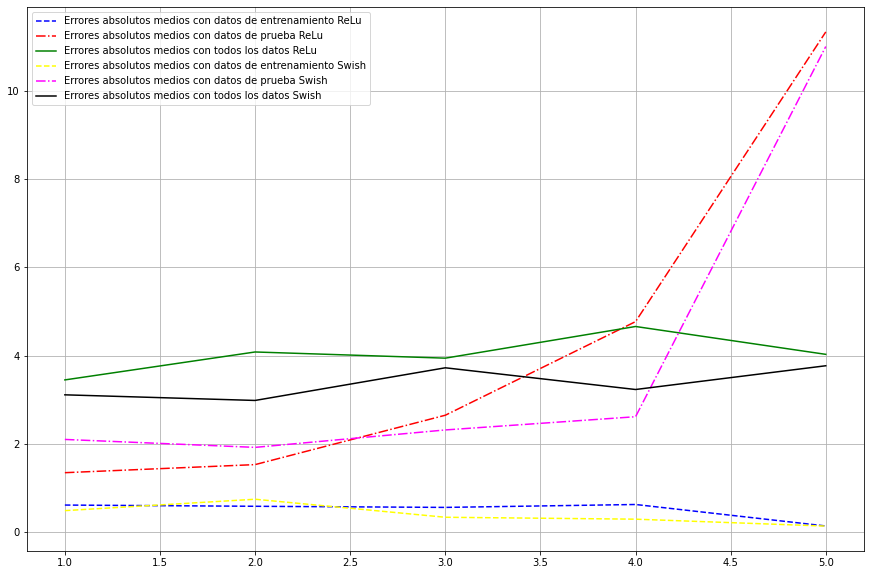

In [ ]:
plt.figure(figsize=(15,10))
linestyles = ["dashed", "dashdot", "solid"]*2
colors = ["blue", "red", "green", "yellow", "magenta", "black"]
points = [mean_abs_errs_relu_e1, mean_abs_errs_relu_e2, mean_abs_errs_relu_e3,
          mean_abs_errs_swish_e1, mean_abs_errs_swish_e2, mean_abs_errs_swish_e3]
labels = ["Errores absolutos medios con datos de entrenamiento ReLu",
          "Errores absolutos medios con datos de prueba ReLu",
          "Errores absolutos medios con todos los datos ReLu",
          "Errores absolutos medios con datos de entrenamiento Swish",
          "Errores absolutos medios con datos de prueba Swish",
          "Errores absolutos medios con todos los datos Swish"]
for i in range(6):
    plt.plot(range(1, 6), points[i], linestyle=linestyles[i], color=colors[i], label=labels[i])
plt.grid(True)
plt.legend()